In [1]:
import awkward as ak
import os
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import warnings
import matplotlib.pyplot as plt
import numpy as np
import hist
import json
import xgboost as xgb
import pickle
import mplhep as hep
from scipy.stats import poisson

In [2]:
plt.style.use(hep.style.CMS)

In [3]:
qcd = {}
path = '/project01/ndcms/cmoore24/skims/gluon_finding/old/mc/'
for i in os.listdir(path):
    if 'qcd' in i:
        qcd_sample = ak.from_parquet(f'{path}/{i}/*')
        qcd_sample['GenJetAK8'] = qcd_sample.GenJetAK8[qcd_sample.goodjets.genJetAK8Idx]
        qcd_sample['goodjets', 'isGluon'] = (qcd_sample.GenJetAK8.partonFlavour == 21)

        qcd_sample["goodjets"] = qcd_sample.goodjets[abs(qcd_sample.goodjets.eta) <= 2.4]
        mask = ~ak.is_none(ak.firsts(qcd_sample.goodjets))
        qcd_sample = qcd_sample[mask]
              
        qcd[i] = qcd_sample

In [4]:
data = {}
path = '/project01/ndcms/cmoore24/skims/gluon_finding/old/data/samples'
for i in os.listdir(path):
    if 'Jet' in i:
        sample = ak.from_parquet(f'{path}/{i}/*')
        data[i] = sample

In [5]:
train = 'kinematics'
trees = '5000'

In [6]:
hgg = ak.from_parquet('/cms/cephfs/data/store/user/cmoore24/skims/full_skims/nolepton/mc/2017/hgg/*', columns=['goodjets'])

In [6]:
path = f'/scratch365/cmoore24/training/hgg/quark_gluon/output/{train}/{trees}'
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [7]:
feature_names = [
    'area',
    'eta',
    'mass',
    'msoftdrop',
    'n2b1',
    'n3b1',
    'phi',
    'pt',
    'tau1',
    'tau2',
    'tau3',
    'tau4',
]

In [8]:
for i in qcd:
    print(f'Doing {i}')
    qcd_np_0 = np.column_stack([ak.to_numpy(qcd[i].goodjets[feature][:,0]) for feature in feature_names])
    qcd_np_0 = scaler.transform(qcd_np_0)
    qcd_xgb_0 = xgb.DMatrix(qcd_np_0, feature_names=feature_names)
    leading_pred = ak.unflatten(bst.predict(qcd_xgb_0), counts=1)

    # qcd_np_1 = np.column_stack([ak.to_numpy(qcd[i].goodjets[feature][:,1]) for feature in feature_names])
    # qcd_np_1 = scaler.transform(qcd_np_1)
    # qcd_xgb_1 = xgb.DMatrix(qcd_np_1, feature_names=feature_names)
    # subleading_pred = ak.unflatten(bst.predict(qcd_xgb_1), counts=1)

    # qcd_np_2 = np.column_stack([ak.to_numpy(qcd[i].goodjets[feature][:,2]) for feature in feature_names])
    # qcd_np_2 = scaler.transform(qcd_np_2)
    # qcd_xgb_2 = xgb.DMatrix(qcd_np_2, feature_names=feature_names)
    # softest_pred = ak.unflatten(bst.predict(qcd_xgb_2), counts=1)

    qcd[i]['goodjets', 'GluonBDT_0'] = leading_pred
    # qcd[i]['goodjets', 'GluonBDT_1'] = subleading_pred
    # qcd[i]['goodjets', 'GluonBDT_2'] = softest_pred

Doing qcd_1000to1400
Doing qcd_1400to1800
Doing qcd_1800to2400
Doing qcd_2400to3200
Doing qcd_3200toInf
Doing qcd_470to600
Doing qcd_600to800
Doing qcd_800to1000


In [9]:
qcd_is_gluon = {}
for i in qcd:
    qcd_is_gluon[i] = qcd[i][qcd[i].goodjets[:,0].isGluon]

qcd_no_gluon = {}
for i in qcd:
    qcd_no_gluon[i] = qcd[i][~qcd[i].goodjets[:,0].isGluon]

In [10]:
for i in data:
    print(f'Doing {i}')
    data_np_0 = np.column_stack([ak.to_numpy(data[i].goodjets[feature][:,0]) for feature in feature_names])
    data_np_0 = scaler.transform(data_np_0)
    data_xgb_0 = xgb.DMatrix(data_np_0, feature_names=feature_names)
    leading_pred = ak.unflatten(bst.predict(data_xgb_0), counts=1)

    # data_np_1 = np.column_stack([ak.to_numpy(data[i].goodjets[feature][:,1]) for feature in feature_names])
    # data_np_1 = scaler.transform(data_np_1)
    # data_xgb_1 = xgb.DMatrix(data_np_1, feature_names=feature_names)
    # subleading_pred = ak.unflatten(bst.predict(data_xgb_1), counts=1)

    # data_np_2 = np.column_stack([ak.to_numpy(data[i].goodjets[feature][:,2]) for feature in feature_names])
    # data_np_2 = scaler.transform(data_np_2)
    # data_xgb_2 = xgb.DMatrix(data_np_2, feature_names=feature_names)
    # softest_pred = ak.unflatten(bst.predict(data_xgb_2), counts=1)
    
    data[i]['goodjets', 'GluonBDT_0'] = leading_pred
    # data[i]['goodjets', 'GluonBDT_1'] = subleading_pred
    # data[i]['goodjets', 'GluonBDT_2'] = softest_pred

Doing JetHT_Run2017B_220701_194050
Doing JetHT_Run2017B_240313_161752
Doing JetHT_Run2017C_220701_194023
Doing JetHT_Run2017D_220701_193930
Doing JetHT_Run2017D_240313_161628
Doing JetHT_Run2017E_220701_193905
Doing JetHT_Run2017E_240313_161541
Doing JetHT_Run2017F_220701_193956
Doing JetHT_Run2017F_220701_193956_2
Doing JetHT_Run2017F_240313_161657


In [11]:
hgg_np_0 = np.column_stack([ak.to_numpy(hgg.goodjets[feature]) for feature in feature_names])
hgg_np_0 = scaler.transform(hgg_np_0)
hgg_xgb_0 = xgb.DMatrix(hgg_np_0, feature_names=feature_names)
leading_pred = ak.unflatten(bst.predict(hgg_xgb_0), counts=1)
hgg['goodjets', 'GluonBDT_0'] = leading_pred

NameError: name 'hgg' is not defined

In [23]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)['2017']

In [24]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [25]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [26]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [27]:
def make_scaled_hist(group, prefix, var_name, range_down, range_up, bins=40, which_index=None, absv=False):
    hists = {}
    for i in group:
        new_hist = (hist.Hist.new.Reg(bins, range_down, range_up,name='variable',label=var_name).Weight())
        if which_index==None:
            to_fill = group[i][prefix][var_name]
        else:
            temp = group[i][(abs(group[i]['goodjets']['eta'][:,which_index]) >= 0)]
            to_fill = temp[prefix][var_name][:,which_index]
        if absv:
            to_fill = abs(to_fill)
        new_hist.fill(variable=to_fill)
        hists[i] = new_hist
        
    for i in hists:
        scale = ((41.5*(xsecs[i]*1000))/totals[i])
        hists[i].view(flow=True)[:] *= scale

    sum_hist = sum([hists[i] for i in hists])

    return sum_hist

In [28]:
bdt_score_0 = make_scaled_hist(qcd, 'goodjets', 'GluonBDT_0',
                             0, 1, 40, 0, absv=False)
bdt_score_true = make_scaled_hist(qcd_is_gluon, 'goodjets', 'GluonBDT_0',
                             0, 1, 40, 0, absv=False)
bdt_score_false = make_scaled_hist(qcd_no_gluon, 'goodjets', 'GluonBDT_0',
                             0, 1, 40, 0, absv=False)
# bdt_score_1 = make_scaled_hist(qcd, 'goodjets', 'GluonBDT_1',
#                              0, 1, 40, 1, absv=False)
# bdt_score_2 = make_scaled_hist(qcd, 'goodjets', 'GluonBDT_2',
#                              0, 1, 40, 2, absv=False)

In [29]:
data_arr = ak.concatenate([data[i] for i in data])

In [30]:
# bdt_score_0.plot1d(label='Leading Jet BDT Score', density=False, yerr=False)
# plt.hist(ak.firsts(data_arr.goodjets.GluonBDT_0), bins=40, histtype='step', label='Data Leading', range=(0,1), density=True)

# bdt_score_1.plot1d(label='Monte Carlo SubLeading', density=True, yerr=False)
# plt.hist(ak.firsts(data_arr.goodjets.GluonBDT_1), bins=40, histtype='step', label='Data SubLeading', range=(0,1), density=True)

# bdt_score_2.plot1d(label='Monte Carlo Soft', density=True, yerr=False)
# plt.hist(ak.firsts(data_arr.goodjets.GluonBDT_2), bins=40, histtype='step', label='Data Soft', range=(0,1), density=True)

# plt.title('Gluon Score of MC QCD TriJet')

# plt.legend()
# plt.xlabel('GluonBDT')
# plt.show()

In [31]:
# bdt_score_0.plot1d(label='Monte Carlo Leading', density=True, yerr=False)
# plt.hist(ak.firsts(data_arr.goodjets.GluonBDT_0), bins=40, histtype='step', label='Data Leading', range=(0,1), density=True)

# bdt_score_1.plot1d(label='Monte Carlo SubLeading', density=True, yerr=False)
# plt.hist(ak.firsts(data_arr.goodjets.GluonBDT_1), bins=40, histtype='step', label='Data SubLeading', range=(0,1), density=True)

# bdt_score_2.plot1d(label='Monte Carlo Soft', density=True, yerr=False)
# plt.hist(ak.firsts(data_arr.goodjets.GluonBDT_2), bins=40, histtype='step', label='Data Soft', range=(0,1), density=True)

# plt.title('Gluon Score of Data TriJets')

# plt.legend()
# plt.show()

In [32]:
bdt_score_data = hist.Hist.new.Reg(40, 0, 1, name='variable', label='variable').Weight()
temp_data = data_arr[(abs(data_arr.goodjets.eta[:,0]) >= 0)]
bdt_score_data.fill(variable=ak.firsts(temp_data.goodjets.GluonBDT_0));

# hgg_score = hist.Hist.new.Reg(40, 0, 1, name='variable', label='variable').Weight()
# temp_hgg = hgg[(abs(hgg.goodjets.eta) >= 1.44)]
# hgg_score.fill(variable=ak.firsts(temp_hgg.goodjets.GluonBDT_0));

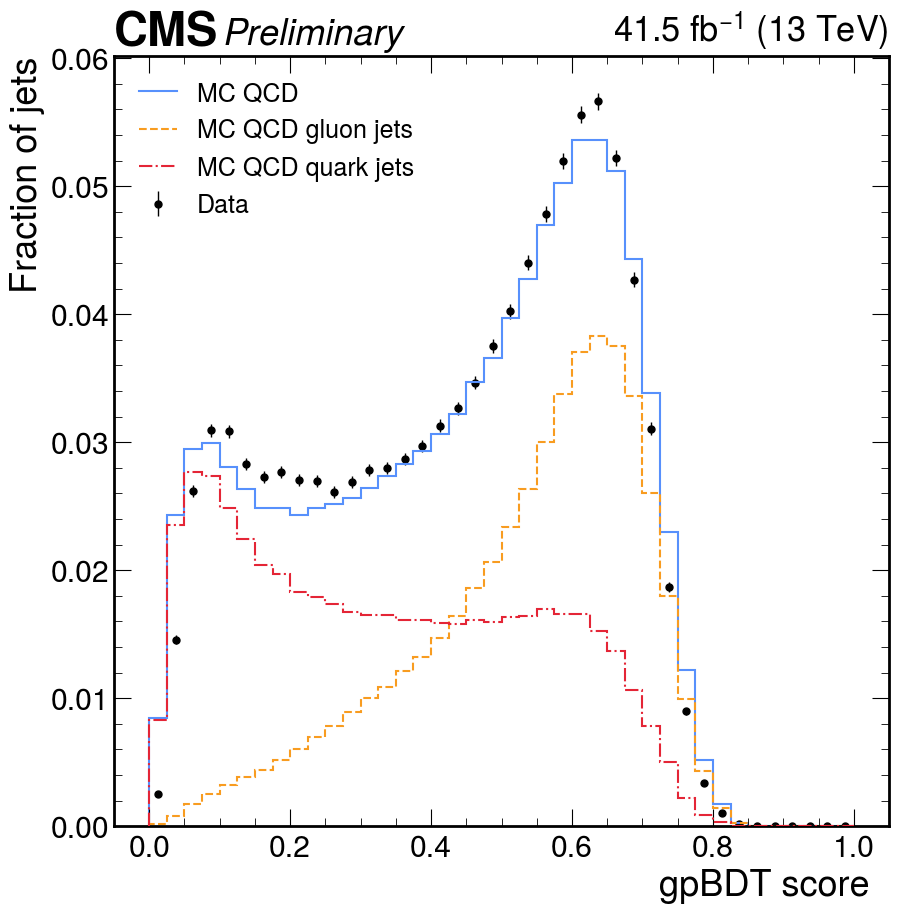

In [33]:
from matplotlib.lines import Line2D
from hist.intervals import poisson_interval
bdt_score_0_norm = bdt_score_0 / bdt_score_0.values().sum()
bdt_score_0_norm.plot1d(label='MC QCD', yerr=False, linestyle='-', zorder=1, color='C0')
# bdt_score_0_norm.plot1d(zorder=1, )

bdt_score_true_norm = bdt_score_true / bdt_score_0.values().sum()
bdt_score_true_norm.plot1d(label='MC QCD gluon jets', yerr=False, linestyle='--', zorder=2, color='C1')

bdt_score_false_norm = bdt_score_false / bdt_score_0.values().sum()
bdt_score_false_norm.plot1d(label='MC QCD quark jets', yerr=False, linestyle='-.', zorder=3, color='C2')

bdt_score_data_norm = bdt_score_data / bdt_score_data.values().sum()
bdt_score_data_norm.plot1d(label='Data', zorder=0, color='k', histtype='errorbar')

# hgg_score_norm = hgg_score / hgg_score.values().sum()
# (hgg_score_norm * 0.6).plot1d(label=r'SM $H \to GluGlu$', yerr=False, linestyle=':', zorder=1, color='C3')

# Decorations
hep.cms.label(label='Preliminary', lumi='41.5', data=True)
plt.xlabel('gpBDT score', x=0.975)
plt.ylabel('Fraction of jets')

plt.legend(fontsize=18)
plt.show()

In [26]:
lead_per = {}
lead_counts = {}

for j in range(0, 100, 1):
    qcd_cut = {}
    for i in qcd:
        sample_goodjets = qcd[i].goodjets[(qcd[i].goodjets.GluonBDT_0 >= j/100) & (qcd[i].goodjets.pt <= 1000)]
    
        mask = ~ak.is_none(ak.firsts(sample_goodjets))
        qcd_sample = qcd[i][mask]
    
        qcd_cut[i] = qcd_sample

    qcd_leadcounts = make_scaled_hist(qcd_cut, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 0, absv=True)
    
    lead_per[str(j)] = sum(qcd_leadcounts[20:].values()) / (sum(qcd_leadcounts[:].values()))
    lead_counts[str(j)] = sum(qcd_leadcounts[:].values())

/tmp/ipykernel_4000038/4186987590.py:16: RuntimeWarning: invalid value encountered in scalar divide
  lead_per[str(j)] = sum(qcd_leadcounts[20:].values()) / (sum(qcd_leadcounts[:].values()))


In [25]:
# sub_per = {}
# sub_counts = {}

# for j in range(0, 100, 1):
#     qcd_cut = {}
#     for i in qcd:
#         sample_goodjets = qcd[i].goodjets[(qcd[i].goodjets.GluonBDT_1 >= j/100) & (qcd[i].goodjets.pt <= 1000)]
    
#         mask = ~ak.is_none(ak.firsts(sample_goodjets))
#         qcd_sample = qcd[i][mask]
    
#         qcd_cut[i] = qcd_sample

#     qcd_subcounts = make_scaled_hist(qcd_cut, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 1, absv=True)

#     sub_per[str(j)] = sum(qcd_subcounts[20:].values()) / (sum(qcd_subcounts[:].values()))
#     sub_counts[str(j)] = sum(qcd_subcounts[:].values())

In [26]:
soft_per = {}
soft_counts = {}

for j in range(0, 100, 1):
    qcd_cut = {}
    for i in qcd:
        sample_goodjets = qcd[i].goodjets[(qcd[i].goodjets.GluonBDT_2 >= j/100) & (qcd[i].goodjets.pt <= 1000)]
    
        mask = ~ak.is_none(ak.firsts(sample_goodjets))
        qcd_sample = qcd[i][mask]
    
        qcd_cut[i] = qcd_sample

    qcd_softcounts = make_scaled_hist(qcd_cut, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 2, absv=True)
    
    soft_per[str(j)] = sum(qcd_softcounts[20:].values()) / (sum(qcd_softcounts[:].values()))
    soft_counts[str(j)] = sum(qcd_softcounts[:].values())

AttributeError: no field named 'GluonBDT_2'

In [ ]:
plt.scatter(x=[int(i)/100 for i in list(lead_per.keys())], y=list(lead_per.values()), label='Leading')
plt.scatter(x=[int(i)/100 for i in list(sub_per.keys())], y=list(sub_per.values()), label='SubLeading')
plt.scatter(x=[int(i)/100 for i in list(soft_per.keys())], y=list(soft_per.values()), label='Softest')
plt.title('Gluon Purity at Various BDT Cuts')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
top_bin=80
plt.scatter(x=list(lead_per.values())[:top_bin], y=list(lead_counts.values())[:top_bin]/list(lead_counts.values())[0], label='Leading')
# plt.scatter(x=list(sub_per.values())[:top_bin], y=list(sub_counts.values())[:top_bin], label='Subleading')
# plt.scatter(x=list(soft_per.values())[:top_bin], y=list(soft_counts.values())[:top_bin], label='Softest')
plt.title('Event Counts at Various BDT Cuts')
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Gluon Purity')
plt.ylabel('Number of Events')
plt.show()

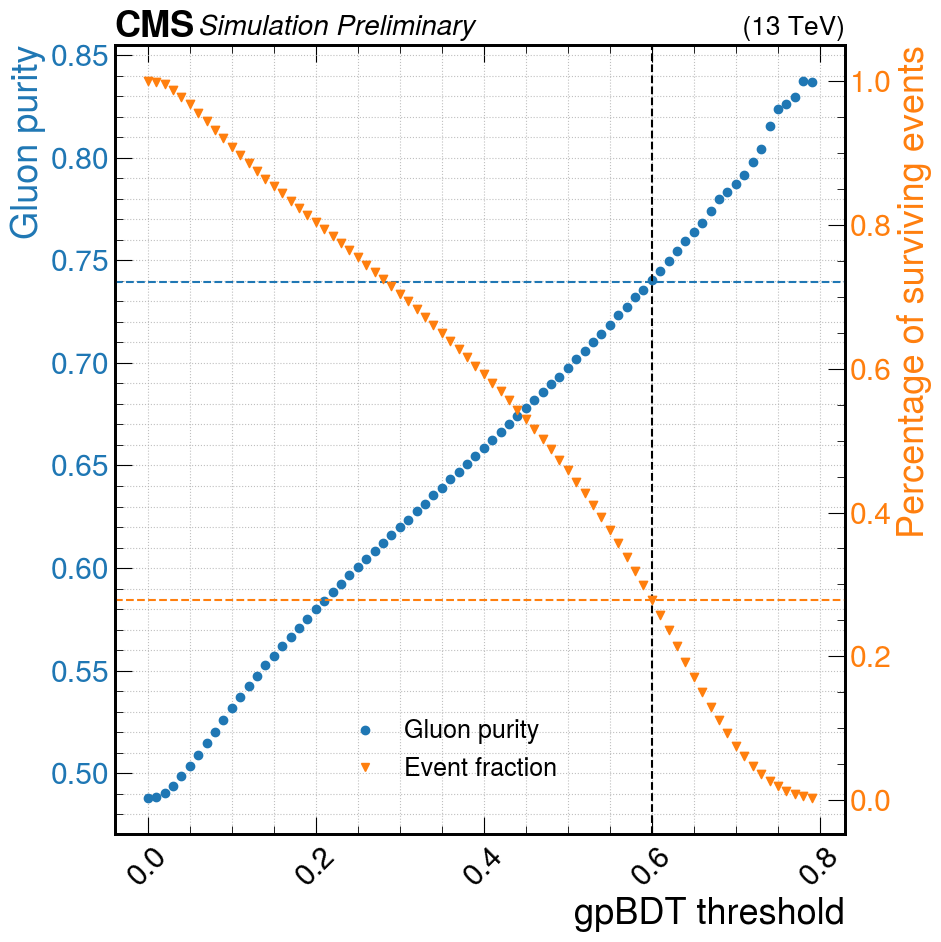

In [28]:
fig, ax1 = plt.subplots()

top_bin=80
x_vals = [int(i)/100 for i in list(lead_per.keys())][:top_bin]
y1 = list(lead_per.values())[:top_bin]
y2 = list(lead_counts.values())[:top_bin] / list(lead_counts.values())[0]

ax1.scatter(x_vals, y1, color='tab:blue', label='Gluon purity', zorder=5)
ax1.set_ylabel('Gluon purity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('gpBDT threshold')
# ax1.set_title('Gluon Purity and Event Counts at Various BDT Cuts')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.scatter(x_vals, y2, color='tab:orange', label='Event count', zorder=2, marker='v')
ax2.set_ylabel('Percentage of surviving events', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

hep.cms.label('Preliminary', fontsize=20)

plt.axvline(x=0.6, color='black', linestyle='--', zorder=0)
plt.axhline(y=0.72, color='tab:blue', linestyle='--', zorder=1)
plt.axhline(y=0.279, color='tab:orange', linestyle='--', zorder=1)

ax1.grid(which='both')
ax2.grid(False)

custom_lines = [
    Line2D([0], [0], color='tab:blue', marker='o', linestyle=' '),
    Line2D([0], [0], color='tab:orange', marker='v', linestyle=' '),
]

plt.legend(custom_lines, ['Gluon purity', 'Event fraction'], fontsize=18, loc=(0.3,0.05))
plt.tight_layout()
plt.show()

In [ ]:
top_bin = 80
plt.grid(True)
plt.scatter(x=list(lead_per.values())[:top_bin], y=list(lead_counts.values())[:top_bin], label='Leading')
plt.scatter(x=list(sub_per.values())[:top_bin], y=list(sub_counts.values())[:top_bin], label='Subleading')
plt.scatter(x=list(soft_per.values())[:top_bin], y=list(soft_counts.values())[:top_bin], label='Softest')

highlight_x, highlight_y = 0.764, 29795.184559730293
plt.scatter([highlight_x], [highlight_y], s=50, facecolors='tab:blue', edgecolors='red', linewidths=2, label='BDT 0.65, Gluon 76.4%')

highlight_x, highlight_y = 0.74, 48403.08205697527
plt.scatter([highlight_x], [highlight_y], s=50, facecolors='tab:blue', edgecolors='purple', linewidths=2, label='BDT 0.60, Gluon 74%')

plt.axvline(x=0.70, color='black', linestyle='--')
# plt.axvline(x=0.75, color='black', linestyle='--')

plt.axhline(y=25000, color='black', linestyle='--')
plt.axhline(y=50000, color='black', linestyle='--')

plt.title('Event Counts at Various Gluon Purities')
plt.xticks(rotation=0)
plt.xlabel('Gluon Purity')
plt.ylabel('Number of Events')
plt.legend()
plt.show()

In [94]:
ak.Array([list(lead_counts.keys())[:100], list(lead_counts.values())[:100]/list(lead_counts.values())[0], list(lead_per.values())[:100]])[:,60]

<Array ['60', 0.279, 0.74] type='3 * union[string, float64]'>

In [27]:
ak.Array([list(lead_counts.keys())[:20], list(lead_counts.values())[:20], list(lead_per.values())[:20]])[:,12][1]

153703.09511207734

In [28]:
one = ak.unflatten(ak.from_numpy(np.ones(10)), counts=1)
zero = ak.unflatten(ak.from_numpy(np.zeros(10)), counts=1)
two = ak.unflatten(ak.from_numpy(np.ones(10) + 1), counts=1)

In [29]:
ak.concatenate([zero,one,two], axis=1)

<Array [[0, 1, 2], [0, 1, 2], ..., [0, ...], [0, 1, 2]] type='10 * 3 * float64'>

In [98]:
msd_0 = make_scaled_hist(qcd, 'goodjets', 'msoftdrop',
                             40, 200, 40, 0, absv=False)
qcd_cut = {}
for i in qcd:
        sample_goodjets = qcd[i].goodjets[(qcd[i].goodjets.GluonBDT_0 >= 0.6)]
    
        mask = ~ak.is_none(ak.firsts(sample_goodjets))
        qcd_sample = qcd[i][mask]
    
        qcd_cut[i] = qcd_sample

msd_cut = make_scaled_hist(qcd_cut, 'goodjets', 'msoftdrop',
                             40, 200, 40, 0, absv=False)
parton_cut = make_scaled_hist(qcd_cut, 'GenJetAK8', 'partonFlavour',
                              0, 22, 22, 0, absv=True)
parton = make_scaled_hist(qcd, 'GenJetAK8', 'partonFlavour',
                          0, 22, 22, 0, absv=True)

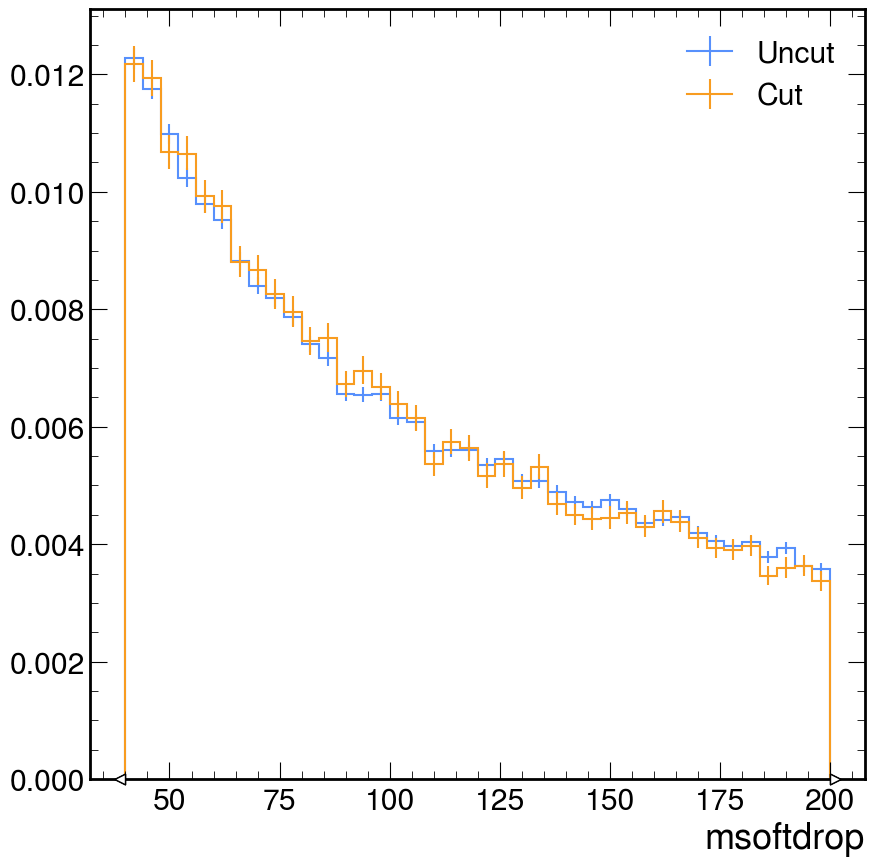

In [99]:
msd_0.plot1d(label='Uncut', density=True)
msd_cut.plot1d(label='Cut', density=True)
plt.legend()
plt.show()

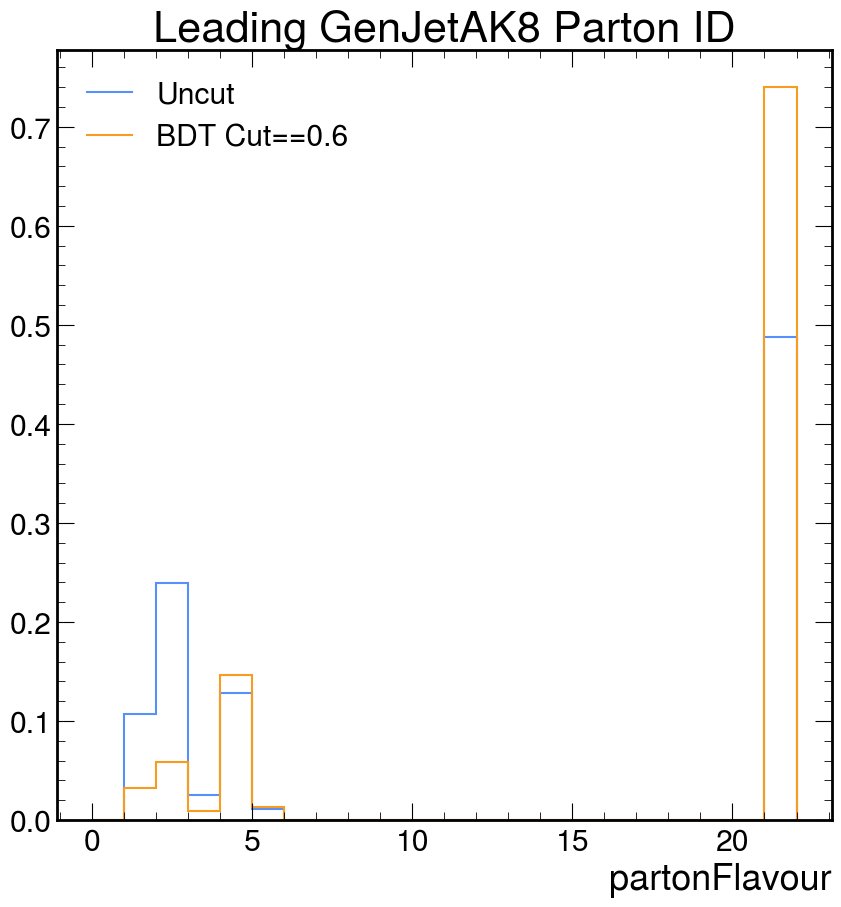

In [100]:
parton.plot1d(label='Uncut', density=True, yerr=False)
parton_cut.plot1d(label='BDT Cut==0.6', density=True, yerr=False)
plt.legend()
plt.title('Leading GenJetAK8 Parton ID')
plt.show()

In [101]:
ak.where(qcd_cut['qcd_800to1000'].GenJetAK8.partonFlavour[:,0] != 21)

(<Array [1, 4, 5, 6, ..., 120191, 120192, 120193, 120197] type='35776 * int64'>,)

In [51]:
lead_counts['60'] / lead_counts['0']

0.27879714381446374